# Memory_rate

In [83]:
pip install chromedriver-binary==97.0.4692.71 

  Created wheel for chromedriver-binary: filename=chromedriver_binary-97.0.4692.71.0-py3-none-any.whl size=8288674 sha256=28de4bd003d8dc26d6a8334ee20e007df6213f5169e953d8bf74ed6172fa1a13
  Stored in directory: /Users/hjm.f/Library/Caches/pip/wheels/b6/a7/b1/a9bba9f0631d0ff8c9843b47abf0bb61a15d8cf8c6c574e051
Successfully built chromedriver-binary
  Attempting uninstall: chromedriver-binary
    Found existing installation: chromedriver-binary 95.0.4638.17.0
    Uninstalling chromedriver-binary-95.0.4638.17.0:
      Successfully uninstalled chromedriver-binary-95.0.4638.17.0
Note: you may need to restart the kernel to use updated packages.


In [40]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 100000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       hb|   3349907|
|              pred_table0|    572339|
|              pred_table1|    337353|
|              pred_table2|    236350|
|                   tansho|   1780983|


In [1]:
del jockey_results

NameError: name 'jockey_results' is not defined

|過去レースデータ(訓練データ)|加工内容|出馬表データ|
|:--:|:--:|:--:|
|r.data||st.data|
|↓<br> r.preprocessing()<br>↓|前処理<br>|↓<br>st.preprocessing()<br>↓|
|r.data_p||st.data_p|
|↓<br>r.merge_horse_results(hr)<br>↓|馬の過去成績データ追加<br>|↓<br>st.merge_horse_results(hr)<br>↓|
|r.data_h||st.data_h|
|↓<br>r.merge_jrs()<br>↓|騎手データ追加<br>|↓<br>st.merge_jrs()<br>↓|
|r.data_j||st.data_j|
|↓<br>r.merge_peds()<br>↓|血統データ追加<br>|↓<br>st.merge_peds()<br>↓|
|r.data_pe||st.data_pe|
|↓<br>r.process_categorical()<br>↓|カテゴリ変数処置<br>|↓<br>st.process_categorical()<br>↓|
|r.data_c||st.data_c|

# Import

In [2]:
import datetime
import time
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import dataframe_image as dfi
from scipy.special import comb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re

import optuna
import optuna.integration.lightgbm as lgb_o
from selenium.webdriver import Chrome, ChromeOptions
import chromedriver_binary
import lightgbm as lgb
#import xgboost as xgb
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle5 as pickle
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from tensorflow import keras
from keras import models, layers
from sklearn import preprocessing
import statistics
from scipy.stats import norm, gaussian_kde
from scipy import optimize, integrate.cumtrapz
import scipy as sp
import math
from itertools import combinations, permutations
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Code

In [3]:
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame() #raw data
        self.data_p = pd.DataFrame() #after preprocessing
        self.data_c = pd.DataFrame() #after processing categorical features
        #self.data_num_rate = pd.DataFrame()
        
    def merge_horse_results(self, hr, n_samples_list=[1,2,3,4,5,6]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = hr.merge_all(self.data_p, n_samples=n_samples)
        
        self.data_p['interval'] = (self.data_p['date'] - self.data_p['latest']).dt.days
        self.data_p['interval'] = self.data_p['interval'].map(lambda x: math.log(x) if x>0 else 0)
        self.data_p.drop(['latest'], axis=1, inplace=True)

    def merge_jockey_results(self, jr, n_samples_list=[60,180]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = jr.merge_all(self.data_p, n_samples=n_samples)
        #self.data_j.drop(['place'], axis=1, inplace=True)
        
    def merge_trainer_results(self, tr, n_samples_list=[180]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = tr.merge_all(self.data_p, n_samples=n_samples)
    
    #def process_categorical(self, le_horse, le_jockey, le_trainer, results_m,st=False):#le:Label Encorder
    def process_categorical(self, results_m,st=False):#le:Label Encorder
        df = self.data_p.copy()
        
        #211230 idは使用していないので不要と判断しでコメントアウト
        '''
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        mask_trainer = df['trainer_id'].isin(le_trainer.classes_)
        new_trainer_id = df['trainer_id'].mask(mask_trainer).dropna().unique()
        le_trainer.classes_ = np.concatenate([le_trainer.classes_, new_trainer_id])
        df['trainer_id'] = le_trainer.transform(df['trainer_id'])
        
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        df['trainer_id'] = df['trainer_id'].astype('category')
        '''
        df.drop(['horse_id','jockey_id','trainer_id'], axis=1, inplace=True)
        

        race_types = results_m['race_type'].unique()
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df = pd.get_dummies(df, columns=['race_type'])
        
        df['weather'] = df['weather'].map(weather_dict).fillna('0').astype(int)
        df['sex'] = df['sex'].map(sex_dict).fillna('0').astype(int)
        
        df['h_rank/heads_gap'] = 2*(df['h_rank/heads_2R'] - df['h_rank/heads_1R'])
        df['h_rank/heads/grade_gap'] = 2*(df['h_rank/heads/grade_2R'] - df['h_rank/heads/grade_1R'])
        df['spurt_gap'] = 2*(df['spurt_2R'] - df['spurt_1R'])
        df['speed_gap'] = 2*(df['speed_2R'] - df['speed_1R'])
        df['course_gap'] = df['course_len']-df['course_len_mean']
        df['race_class'] = df['No.1_sum'].groupby(level=0).mean()
        df['horse_prize_mean'] = df['prize_sum'].groupby(level=0).mean()
        df['prize_gap'] = df['prize_sum'] - df['horse_prize_mean']
        df['class_gap'] = df['No.1_sum'] - df['race_class']
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['No.1/days'] = (df['No.1_sum']/df['days'])
        df['No.3/days'] = (df['No.3_sum']/df['days'])
        df['prize/days'] = (df['prize_sum']/df['days'])
        df['jw_rate_120R'] = df['jw_rate_120R'].map(lambda x: math.log(x) if x>0 else 0)
        df['jp_rate_120R'] = df['jp_rate_120R'].map(lambda x: math.log(x) if x>0 else 0)
        df['tw_rate_120R'] = df['tw_rate_120R'].map(lambda x: math.log(x) if x>0 else 0)
        df['tp_rate_120R'] = df['tp_rate_120R'].map(lambda x: math.log(x) if x>0 else 0)
        df['place'] = df['place'].astype(int)
        
        def growth_1(x):
            z = 0.004506*x*x*x - 0.1219*x*x + 1.005*x - 1.877
            return z
        def growth_0(x):
            z = 0.009971*x*x*x - 0.2207*x*x + 1.567*x - 2.984
            return z
        def growth_rate_1(x):
            z = 0.013518*x*x - 0.2438*x + 1.005
            return z
        def growth_rate_0(x):
            z = 0.029913*x*x - 0.4414*x + 1.567
            return z

        df1 = df[df['sex']== -1]
        df0 = df[df['sex']!= -1]

        df1['growth'] = growth_1(df1['days'])
        df0['growth'] = growth_0(df0['days'])
        df1['growth_rate'] = growth_rate_1(df1['days'])
        df0['growth_rate'] = growth_rate_0(df0['days'])

        df = pd.concat([df1,df0])
        df = df.loc[:,~df.columns.duplicated()]
        def style_judge(x):
                if x<3: 
                    return 0
                if x>=3:
                    if x<6:
                        return 1
                    if x>=6:
                        if x<9:
                            return 2
                        if x>=9:
                            if x<12:
                                return 3
                            if x>=12:
                                if x<15:
                                    return 4
                                if x>=15:
                                    return 5
                            
        if st==False:
            swr = df[['race_type_芝','place','course_len','1st_corner_4R','rank<3','単勝']].copy()
            
            swr['style'] = swr['1st_corner_4R'].map(lambda x : style_judge(x))
            wins = swr[swr['rank<3']==1]
            swr_count = swr.groupby(['race_type_芝','place','course_len','style'])
            wins_count = wins.groupby(['race_type_芝','place','course_len','style'])
            df_swr = wins_count.count()/swr_count.count()

            df_swr['style_winrate'] = df_swr['単勝']#単勝じゃなくてもいい
            df['style'] = df['1st_corner_4R'].map(lambda x : style_judge(x))
            df = df.join(df_swr['style_winrate'],on=['race_type_芝','place','course_len','style'])
            del swr, wins, swr_count, wins_count,
            df_swr.to_pickle('running_style_winrate.pickle')
        
        if st==True:
            df['style'] = df['1st_corner_4R'].map(lambda x : style_judge(x))
            df_swr = pd.read_pickle('running_style_winrate.pickle')
            df = df.join(df_swr['style_winrate'],on=['race_type_芝','place','course_len','style'])
            
            
        
        self.data_c = df
        
class ShutubaTable(DataProcessor):
    def __init__(self,shutuba_tables):
        super(ShutubaTable,self).__init__()
        self.data = shutuba_tables
    @classmethod
    def scrape(cls,race_id_list,date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0,drop=True).T
            
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text,'html.parser')
            
            texts = soup.find('div',attrs={'class':'RaceData01'}).text
            texts = re.findall(r'\w+',texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+',text)[0])] * len(df)
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    df['weather'] = [text] * len(df)
                if text in ['良', '稍重', '重']:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '稍' in text:
                    df['ground_state'] = ['稍重'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)

            df['date'] = [date] * len(df)
            
            horse_id_list = []
            horse_td_list = soup.find_all('td',attrs={'class':'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+',td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            
            jockey_id_list = []
            jockey_td_list = soup.find_all('td',attrs={'class':'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+',td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)

            trainer_id_list = []
            trainer_td_list = soup.find_all('td',attrs={'class':'Trainer'})
            for td in trainer_td_list:
                trainer_id = re.findall(r'\d+',td.find('a')['href'])[0]
                trainer_id_list.append(trainer_id)
            

            df["horse_id"] = horse_id_list
            df['jockey_id'] = jockey_id_list
            df["trainer_id"] = trainer_id_list
            
            df.index = [race_id]*len(df)
            data = data.append(df)
            time.sleep(0.1)
            
        return cls(data)
    
    def preprocessing(self,weight=False):
        df = self.data.copy()
        #df['R'] = df.index.str[-2:].astype(int)
        
        df['sex'] = df['性齢'].map(lambda x: str(x)[0])
        #df['age'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)
        df['R'] = df.index.str[-2:].astype(int)
        
        #df.drop(['馬体重(増減)'], axis=1, inplace=True)
        df['jockey_weight'] = df['斤量'].astype(float)
        #1/4馬体重を考慮する
        if weight:
            df = df[df['馬体重(増減)'] != '--']
            df['weight'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(float)
            df['++weight'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].replace('前計不',0).astype(float)
            df['weight_per'] = df['jockey_weight']/df['weight']
        
        df['date'] = pd.to_datetime(df['date'])
        df['waku'] = df['枠'].astype(int)
        df['number'] = df['馬番'].astype(int)
        df['course_len'] = df['course_len'].astype(float)
        df['place'] = df['開催'] = df.index.map(lambda x: str(x)[4:6]).astype(int)
        df['n_horses'] = df.index.map(df.index.value_counts())
        df['month'] = df['date'].dt.month
        df['weather'] = df['weather'].map(weather_dict).fillna('0').astype(int)
        df['sex'] = df['sex'].map(sex_dict).fillna('0').astype(int)
        df['ground'] = df['ground_state'].str.extract(r'(\D+)')[0].map(ground_dict).fillna('5')
        df['ground'] = df['ground'].astype(int)
        df = df[df['ground']!=5]
        df.drop(['ground_state'], axis=1, inplace=True) 
        
        if weight==False:
            df = df[['course_len','date','R','number','waku','jockey_weight','place','month','n_horses','weather','race_type','ground','horse_id','jockey_id','trainer_id','sex',]]
        
        #2/4馬体重を考慮する
        if weight:
            df = df[['course_len','date','R','weight','++weight','number','waku','jockey_weight','weight_per','place','month','n_horses','weather','race_type','ground','horse_id','jockey_id','trainer_id','sex',]]
        
        self.data_p = df
        waku_winrate = pd.read_pickle('waku_winrate.pickle')
        df_join = df.join(waku_winrate['waku_winrate'],on=['place','race_type','course_len','waku'])
        #df_join = df.join(r.data_num_rate['waku_winrate'],on=['place','race_type','course_len','waku'])
        self.data_p = df_join
        
        self.data_p = pd.merge(self.data_p,hb,left_on='horse_id',right_index=True)
        self.data_p['days'] = (self.data_p['date']-self.data_p['birth']).dt.days/365
        
        course_infos = pd.read_excel('course_infos.xlsx')
        self.data_p_merge = self.data_p.merge(course_infos,on=['place','race_type','course_len'],how='left')
        self.data_p_merge.index=self.data_p.index
        self.data_p_merge['last_slope'] = self.data_p_merge['last_ΔH']/self.data_p_merge['last_ΔL']*100
        self.data_p_merge['first_slope'] = self.data_p_merge['first_ΔH']/self.data_p_merge['first_ΔL']*100
        self.data_p = self.data_p_merge.copy()
        
        #self.data_p['race_type'] = self.data_p['race_type'].map(race_type_dict).fillna('0').astype(int)
        
        del df_join,self.data_p_merge
                
class Results(DataProcessor):
    def __init__(self,results):
        super(Results,self).__init__()
        self.data = results
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    def preprocessing(self, year, R, weight=False):
        df = self.data.copy()
        
        df['R'] = df.index.str[-2:].astype(int)
        df['着順'] = pd.to_numeric(df['着順'],errors='coerce')
        df.dropna(subset=['着順'],inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank=1'] = df['着順'].map(lambda x:1 if  x==1 else 0)
        df['rank<2'] = df['着順'].map(lambda x:1 if  x<3 else 0)
        df['rank<3'] = df['着順'].map(lambda x:1 if  x<4 else 0)
        df['rank<5'] = df['着順'].map(lambda x:1 if  x<6 else 0)
        df['rank<8'] = df['着順'].map(lambda x:1 if  x<9 else 0)
        df['sex'] = df['性齢'].map(lambda x: str(x)[0])        
        df['number'] = df['馬番'].astype(int)
        df['waku'] = df['枠番'].astype(int)
        df['jockey_weight'] = df['斤量'].astype(int)
        
        #3/4馬体重を考慮する
        if weight:
            df['weight'] = df['馬体重'].str.split("(", expand=True)[0].astype(float)
            df['++weight'] = df['馬体重'].str.split("(", expand=True)[1].str[:-1].astype(float)
            df['weight_per'] = df['jockey_weight']/df['weight']
        
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].astype(float)
        df['place'] = df.index.map(lambda x: str(x)[4:6]).astype(int)
        df['date'] = pd.to_datetime(df['date'], format="%Y年%m月%d日")
        df['month'] = df['date'].dt.month
        df['n_horses'] = df.index.map(df.index.value_counts())
        df['ground'] = df['ground_state'].str.extract(r'(\D+)')[0].map(ground_dict).fillna('5')
        df['ground'] = df['ground'].astype(int)
        df = df[df['ground']!=5]
        
        ###除外対象
        df = df[df['jockey_id']!='00815']
        df = df[df['jockey_id']!='05074']
        df = df[df['jockey_id']!='05455']
        df = df[df['jockey_id']!='05396']
        df = df[df['trainer_id']!='05681']
        ###
        
        df.drop(['枠番','馬番','斤量','タイム', '着差', '調教師', '性齢','馬名','騎手','馬体重', '人気','owner_id','ground_state'], axis=1, inplace=True)


        self.data_p = df
        self.data_p_rank = df[df['rank<3']==1]
        self.data_p_ = self.data_p[['place','course_len','race_type','着順','waku']]
        self.data_p_rank = self.data_p_rank[['place','course_len','race_type','着順','waku']]
        self.data_p_grp = self.data_p_.groupby(['place','race_type','course_len','waku'])
        self.data_p_rank_grp = self.data_p_rank.groupby(['place','race_type','course_len','waku'])
        self.data_num_rate = self.data_p_rank_grp.count()/self.data_p_grp.count()
        self.data_num_rate['waku_winrate'] = self.data_num_rate['着順'].map(lambda x: 0.5 if x>0.5 else x)
        self.data_num_rate.to_pickle('waku_winrate.pickle')
        waku_winrate = pd.read_pickle('waku_winrate.pickle')
        df_join = df.join(waku_winrate['waku_winrate'],on=['place','race_type','course_len','waku'])
        
        df_join.drop(['着順'], axis=1, inplace=True)
        self.data_p = df_join
        self.data_p['date'] = pd.to_datetime(self.data_p['date'], format="%Y年%m月%d日")
        self.data_p = self.data_p[self.data_p['race_type']!='障害']
        self.data_p = pd.merge(self.data_p,hb,left_on='horse_id',right_index=True)
        self.data_p['days'] = (self.data_p['date']-self.data_p['birth']).dt.days/365
        self.data_p = self.data_p[self.data_p['R'] > R]
        self.data_p = self.data_p[self.data_p['date'] > year]
        
        course_infos = pd.read_excel('course_infos.xlsx')
        self.data_p_merge = self.data_p.merge(course_infos,on=['place','race_type','course_len'],how='left')
        self.data_p_merge.index=self.data_p.index
        self.data_p_merge['last_slope'] = self.data_p_merge['last_ΔH']/self.data_p_merge['last_ΔL']*100
        self.data_p_merge['first_slope'] = self.data_p_merge['first_ΔH']/self.data_p_merge['first_ΔL']*100
        self.data_p = self.data_p_merge.copy()
        
        del df_join, self.data_p_, self.data_p_rank, self.data_p_rank_grp, self.data_p_grp,self.data_p_merge

    def process_categorical(self):
        #self.le_horse = LabelEncoder().fit(self.data_p['horse_id'])
        #self.le_jockey = LabelEncoder().fit(self.data_p['jockey_id'])
        #self.le_trainer = LabelEncoder().fit(self.data_p['trainer_id'])
        #super().process_categorical(self.le_horse,self.le_jockey,self.le_trainer,self.data_p)
        super().process_categorical(self.data_p)

class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','開催','レース名','頭数','オッズ','着順','距離','馬場','馬場指数','タイム','着差','ﾀｲﾑ指数','通過','ペース','上り','賞金','備考']]#'人気',
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.horse_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        df.index.name = 'horse_id'
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )
        
        df['race_grade'] = pd.to_numeric(df1, errors='coerce')
        df.dropna(subset=['race_grade'], inplace=True)
        df['race_grade'] = 1/df['race_grade']
    
        #開催場所
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]
        
        #race_type[芝orダor障]を作成し、[障]を除外
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)#subsetでdrop対象の列を指定
        df['h_rank'] = df['着順'].astype(int)
        df['No.1'] = df['h_rank'].map(lambda x: 1 if x<2 else 0)
        df['No.3'] = df['h_rank'].map(lambda x: 1 if x<4 else 0)
        df['n_entry'] = df['h_rank'].map(lambda x: 1 if x<20 else 0)
        df['h_rank'] = df['h_rank'].astype(int)
        
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)
        
        df['馬場指数'] = pd.to_numeric(df['馬場指数'], errors='coerce')
        df.dropna(subset=['馬場指数'], inplace=True)#subsetでdrop対象の列を指定
        df['ground'] = df['馬場指数'].astype(float)
        df['ground'] = (df['ground'] - df['ground'].min()) / (df['ground'].max() - df['ground'].min())
        df['ground'] = df['ground'].map(lambda x: 0.01 if x==0 else x)

        #距離をintへ変換
        def www(x,n):
            return int(re.findall(r'\d+', x)[0])
        df['距離'] = df['距離'].map(lambda x: www(x,1))
        df['距離'] = pd.to_numeric(df['距離'], errors='coerce')
        df.dropna(subset=['距離'], inplace=True)
        df['course_len'] = df['距離'].astype(int)
        
        df['3F_1st'] = df['ペース'].str.split('-', expand=True)[0].astype(float)
        df['3F_1st'] = 600/df['3F_1st']
        df['3F_last'] = df['ペース'].str.split('-', expand=True)[1].astype(float)
        df['3F_last'] = 600/df['3F_last']
        df['pace'] =  df['3F_last']/df['3F_1st']
        df['pace'] = df.groupby(['place','race_type','course_len','馬場'])['pace'].transform(scale)
        
        
        df['h_rank/heads'] = df['h_rank']/df['heads']
        df['h_rank/heads/grade'] = df['h_rank']/df['heads']/df['race_grade']
        df['h_rank/grade'] = df['h_rank']/df['race_grade']
        df['rank_minmax'] = (df['h_rank/heads'] - df['h_rank/heads'].min()) / (df['h_rank/heads'].max() - df['h_rank/heads'].min())
        df['h_rank/heads/pace'] = df['rank_minmax']/df['pace']
        df['h_rank/heads/ground'] = df['rank_minmax']/df['ground']
        #df['オッズ'] = pd.to_numeric(df['オッズ'], errors='coerce')
        #df.dropna(subset=['オッズ'], inplace=True)
        #df['ozz'] = df['オッズ'].astype(float)
        #df['1/ozz'] = 1/df['ozz']
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
        df['prize'] = df['賞金'].map(lambda x: math.log10(x) if x>0 else 0)
        
        df['上り'] = pd.to_numeric(df['上り'], errors='coerce')
        df.dropna(subset=['上り'], inplace=True)
        df['spurt'] = df['上り'].astype(float)

        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['differ'] = df['着差'].map(lambda x: 0 if x<0 else x)
        df['differ'] = df['differ']*-1
       
        #コーナーへの進入順位をintに変換
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['last_corner'] = df['通過'].map(lambda x: corner(x,4))
        df['1st-rank']  = df['1st_corner']  - df['h_rank']
        df['last-rank'] = df['last_corner'] - df['h_rank']
        df['1st-last']  = df['last_corner'] - df['1st_corner']
        
        time = df['タイム']
        time = time.str.split(':', expand=True)
        #.drop([2], axis=1)
        for n in range(0,2):
            time[n] = pd.to_numeric(time[n], errors='coerce')
        df['time'] = time[0]*60 + time[1]
        df['speed'] = df['course_len']/df['time']
        df['speed'] = df['speed'].map(lambda x: 15.5 if x<15.5 else x)
        df['spurt'] = 600/df['spurt']
        df['spurt'] = df['spurt'].map(lambda x: 15.5 if x<15.5 else x)
        
        df['speed_style1'] = df['speed']/df['3F_1st']
        df['speed_style2'] = df['speed']/df['3F_last']
        df['spurt_style1'] = df['spurt']/df['3F_1st']
        df['spurt_style2'] = df['spurt']/df['3F_last']
        
        df['ﾀｲﾑ指数'] = pd.to_numeric(df['ﾀｲﾑ指数'], errors='coerce')
        df.dropna(subset=['ﾀｲﾑ指数'], inplace=True)#subsetでdrop対象の列を指定
        df['runtime'] = df['ﾀｲﾑ指数'].astype(float)
        
        df['late'] = df['備考'].astype(str).map(lambda x: 1 if '出遅れ' in x else 0 )
        
        df['spurt']  = df.groupby(['place','race_type','course_len','馬場'])['spurt'].transform(scale)
        df['speed']  = df.groupby(['place','race_type','course_len','馬場'])['speed'].transform(scale)
        df['differ'] = df.groupby(['place','race_type','course_len','馬場'])['differ'].transform(scale)
        df['runtime'] = (df['runtime']-df['runtime'].mean())/df['runtime'].std()
        
        df[['h_rank/heads','h_rank/heads/grade','h_rank/grade','h_rank/heads/pace','h_rank/heads/ground','prize','spurt','speed','differ','runtime','speed_style1','speed_style2','spurt_style1','spurt_style2','1st_corner','last_corner','last-rank','No.1','No.3','n_entry']]=\
        df[['h_rank/heads','h_rank/heads/grade','h_rank/grade','h_rank/heads/pace','h_rank/heads/ground','prize','spurt','speed','differ','runtime','speed_style1','speed_style2','spurt_style1','spurt_style2','1st_corner','last_corner','last-rank','No.1','No.3','n_entry']]
        
        self.horse_results = df
        self.target_list      = ['h_rank/heads','h_rank/heads/grade','h_rank/grade','h_rank/heads/pace','h_rank/heads/ground','prize','spurt','speed','differ','runtime','speed_style1','speed_style2','spurt_style1','spurt_style2','1st_corner','last_corner','1st-rank','last-rank']
        self.target_list_sum  = ['prize','No.1','No.3','n_entry']
        self.target_list_max  = ['prize','spurt','speed','differ','runtime']
        self.target_list_min  = ['spurt','speed','differ','runtime']
        self.target_list_mean = ['h_rank/heads','h_rank/heads/grade','h_rank/grade','h_rank/heads/pace','h_rank/heads/ground','race_grade','prize','spurt','speed','differ','runtime',\
                                 'speed_style1','speed_style2','spurt_style1','spurt_style2','course_len','1st_corner','last_corner','1st-rank','last-rank','No.1','No.3','late','pace']
        self.target_list_std  = ['h_rank/heads','h_rank/heads/grade','h_rank/grade','h_rank/heads/pace','h_rank/heads/ground','spurt','speed','differ','runtime','1st_corner','last_corner']
        

    def at_class(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        
        date_last_1st = filtered_df[filtered_df['着順']==1][['date']].groupby(level=0).head(1)
        date_last_1st = date_last_1st.rename(columns={'date': 'date2'})
        filtered_df = pd.merge(filtered_df, date_last_1st, right_index=True, left_index=True, how='left')
        filtered_df['date2'].fillna(pd.to_datetime('2013-12-31 00:00:00'), inplace=True)
        filtered_df = filtered_df[filtered_df['date'] > filtered_df['date2']]
        filtered_df = filtered_df[filtered_df['place']!=11]
        class_ = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_class')
        return class_
    
    def at_max(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        max_ = filtered_df.groupby(level=0)[self.target_list_max].max().add_suffix('_max')
        return max_
    
    def at_min(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        min_ = filtered_df.groupby(level=0)[self.target_list_min].min().add_suffix('_min')
        return min_

    def at_sum(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        sum_ = filtered_df.groupby(level=0)[self.target_list_sum].sum().add_suffix('_sum')
        return sum_
    
    def at_mean(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(level=0)[self.target_list_mean].mean().add_suffix('_mean')
        return mean_

    def at_std(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        std_ = filtered_df.groupby(level=0)[self.target_list_std].std().add_suffix('_std')
        return std_
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))
            
        if n_samples == 1:
            self.latest = filtered_df.groupby('horse_id')['date'].max().rename('latest')

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id', right_index=True, how='left')
                    
        if n_samples == 1:
            merged_df = merged_df.merge(self.at_class(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_max(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_min(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_sum(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_mean(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_std(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.latest, left_on='horse_id',right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class JockeyResults:
    def __init__(self, jockey_results):
        self.jockey_results = jockey_results[['日付','開催','R','レース名','頭数','単勝','着順','距離','馬場','着差','通過','賞金(万円)']]
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.jockey_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )
        
        df['race_grade'] = pd.to_numeric(df0, errors='coerce')
        df.dropna(subset=['race_grade'], inplace=True)
        df['race_grade'] = 1/df['race_grade']
        
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]
        
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        
        df['course_len'] = df['距離'].str.extract(r'(\d+)')
        df['course_len'] = pd.to_numeric(df['course_len'], errors='coerce')
        df.drop(['距離'], axis=1, inplace=True)
        
        df['賞金(万円)'] = pd.to_numeric(df['賞金(万円)'], errors='coerce')
        df['賞金(万円)'] = df['賞金(万円)'].fillna(0)
        df['j_prize'] = df['賞金(万円)'].astype(int).map(lambda x: math.log10(x) if x>0 else 0)
        df.drop(['賞金(万円)'], axis=1, inplace=True)
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['j_rank'] = df['着順'].astype(int)
        df.drop(['着順'], axis=1, inplace=True)
        
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)
        
        df['単勝'] = pd.to_numeric(df['単勝'], errors='coerce')
        df.dropna(subset=['単勝'], inplace=True)
        df['j_ozz'] = df['単勝'].astype(float)
        df['1/j_ozz'] = 1/df['j_ozz']
        
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['j_differ'] = df['着差'].map(lambda x: 0 if x<0 else x)
        df['j_differ'] = -1*df['j_differ']
        
        df['j_rank/heads'] = df['j_rank']/df['heads']
        df['j_rank/heads/grade'] = df['j_rank/heads']/df['race_grade']
        df['j_rank/grade'] = df['j_rank']/df['race_grade']
        
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['j_1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['j_last_corner'] = df['通過'].map(lambda x: corner(x,4))
        df['j_1st-rank']  = df['j_1st_corner']  - df['j_rank']
        df['j_last-rank'] = df['j_last_corner'] - df['j_rank']
        df['j_1st-last'] = df['j_last_corner'] - df['j_1st_corner']
        
        df['jw_rate'] = df['j_rank'].map(lambda x: 1 if x<2 else 0)
        df['jp_rate'] = df['j_rank'].map(lambda x: 1 if x<4 else 0)
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['j_differ'] = df.groupby(['race_type','place'])['j_differ'].transform(scale)
        
        zscore = lambda x: (x - x.mean()) / x.std()
        df[['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_differ']] =\
        df[['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_differ']].transform(zscore)

        self.jockey_results = df
        self.target_list      = ['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_differ','jw_rate','jp_rate']
        self.target_list_mean = ['j_prize','j_differ','j_rank/heads','j_rank/heads/grade','j_rank/grade','jw_rate','jp_rate','j_1st_corner','j_1st-rank','j_1st-last']
    
    def at_mean(self, jockey_id_list, date):
        target_df = self.jockey_results.loc[jockey_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(['jockey_id','race_type','place'])[self.target_list_mean].mean().add_suffix('_mean')
        return mean_
    
    def average(self, jockey_id_list, date, n_samples='all'):
        target_df = self.jockey_results.query('index in @jockey_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))
        

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        jockey_id_list = df['jockey_id']
        self.average(jockey_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='jockey_id', right_index=True, how='left')
        if n_samples == 120:
            merged_df = merged_df.merge(self.at_mean(jockey_id_list, date), left_on=['jockey_id','race_type','place'],right_index=True,how='left')
        
        return merged_df
    
    # r.data_h から取り出した date を元に
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class TrainerResults:
    def __init__(self, trainer_results):
        self.trainer_results = trainer_results[['日付','開催','R','レース名','頭数','単勝','着順','距離','馬場','着差','通過','賞金(万円)']]
        self.preprocessing()
       
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.trainer_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )

        df['race_grade'] = pd.to_numeric(df1, errors='coerce')
        df.dropna(subset=['race_grade'], inplace=True)
        df['race_grade'] = 1/df['race_grade']
        
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]
        
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        
        df['course_len'] = df['距離'].str.extract(r'(\d+)')
        df['course_len'] = pd.to_numeric(df['course_len'], errors='coerce')
        df.drop(['距離'], axis=1, inplace=True)
        
        df['賞金(万円)'] = pd.to_numeric(df['賞金(万円)'], errors='coerce')
        df['賞金(万円)'] = df['賞金(万円)'].fillna(0)
        df['t_prize'] = df['賞金(万円)'].astype(int).map(lambda x: math.log10(x) if x>0 else 0)
        df.drop(['賞金(万円)'], axis=1, inplace=True)
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['t_rank'] = df['着順'].astype(int)
        df.drop(['着順'], axis=1, inplace=True)
        
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)
        
        df['単勝'] = pd.to_numeric(df['単勝'], errors='coerce')
        df.dropna(subset=['単勝'], inplace=True)
        df['t_ozz'] = df['単勝'].astype(float)
        df['1/t_ozz'] = 1/df['t_ozz']
        
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['t_differ'] = df['着差'].map(lambda x: 0 if x<0 else x)
        df['t_differ'] = -1*df['t_differ'].map(lambda x: math.log(x) if x>0 else 0)
        
        df['t_rank/heads'] = df['t_rank']/df['heads']
        df['t_rank/heads/grade'] = df['t_rank/heads']/df['race_grade']
        df['t_rank/grade'] = df['t_rank']/df['race_grade']
        
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['t_1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['t_last_corner'] = df['通過'].map(lambda x: corner(x,4))
        
        df['t_1st-rank']  = df['t_1st_corner']  - df['t_rank']
        df['t_last-rank'] = df['t_last_corner'] - df['t_rank']
        
        df['tw_rate'] = df['t_rank'].map(lambda x: 1 if x<2 else 0)
        df['tp_rate'] = df['t_rank'].map(lambda x: 1 if x<4 else 0)
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['t_differ'] = df.groupby(['race_type','place'])['t_differ'].transform(scale)
        
        zscore = lambda x: (x - x.mean()) / x.std()
        df[['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_differ']] =  df[['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_differ']].transform(zscore)

        self.trainer_results = df
        self.target_list = ['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_differ','tw_rate','tp_rate']
        self.target_list_mean = ['t_prize','t_differ','t_rank/heads','t_rank/heads/grade','t_rank/grade','tw_rate','tp_rate']
        
    def at_mean(self, trainer_id_list, date):
        target_df = self.trainer_results.loc[trainer_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(['trainer_id','race_type','place'])[self.target_list_mean].mean().add_suffix('_mean')
        return mean_
    
    def average(self, trainer_id_list, date, n_samples='all'):
        target_df = self.trainer_results.query('index in @trainer_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        trainer_id_list = df['trainer_id']
        self.average(trainer_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='trainer_id', right_index=True, how='left')
        
        if n_samples == 120:
            merged_df = merged_df.merge(self.at_mean(trainer_id_list, date), left_on=['trainer_id','race_type','place'],right_index=True,how='left')
        return merged_df
    
    # r.data_h から取り出した date を元に
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2,3]]
        tansho.columns = ['win', 'return','ninki']
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho
    
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0]=='馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix('win_')
        return_ = umaren[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0]=='馬単'][[1,2]]
        wins = umatan[1].str.split('→', expand=True)[[0,1]].add_prefix('win_')
        return_ = umatan[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0]=='ワイド'][[1,2]]
        wins = wide[1].str.split('br', expand=True)[[0,1,2]]
        wins = wins.stack().str.split('-', expand=True).add_prefix('win_')
        return_ = wide[2].str.split('br', expand=True)[[0,1,2]]
        return_ = return_.stack().rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property
    def sanrentan(self):
        rentan = self.return_tables[self.return_tables[0]=='三連単'][[1,2]]
        wins = rentan[1].str.split('→', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = rentan[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def sanrenpuku(self):
        renpuku = self.return_tables[self.return_tables[0]=='三連複'][[1,2]]
        wins = renpuku[1].str.split('-', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = renpuku[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

class ModelEvaluator:
    def __init__(self, model, return_tables_path_list):
        self.model = model
        self.rt = Return.read_pickle(return_tables_path_list)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrentan = self.rt.sanrentan
        self.sanrenpuku = self.rt.sanrenpuku
        
    #３着以内に入る馬を予想している
    def predict_proba(self, X, shutuba=False, dl=False, std=True, minmax=False):
        if shutuba:
            proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        else:
            if dl:
                X = X.drop(['単勝'], axis=1)
                X_dl = np.array(X.values)
                X_st = scaler.fit_transform(X_dl)
                proba = pd.Series(self.model.predict(X_st))
            else:
                proba = pd.Series(self.model.predict_proba(X.drop(['単勝'], axis=1))[:, 1], index=X.index)
        
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
        if minmax:
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    #0or1を予想している
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        self.proba = y_pred
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns,"importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['number', '単勝']]
        pred_table['pred'] = self.predict(X, threshold)
        pred_table['score'] = self.proba
        if bet_only:
            return pred_table[pred_table['pred']==1][['number', '単勝', 'score']]
        else:
            return pred_table[['number', '単勝', 'score', 'pred']]
        
    def bet(self, race_id, kind, umaban, amount):
        if kind == 'tansho':
            rt_1R = self.tansho.loc[race_id]
            return_ = (rt_1R['win']==umaban) * rt_1R['return'] * amount/100
        
        if kind == 'fukusho':
            rt_1R = self.fukusho.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1', 'win_2']]==umaban).values * rt_1R[['return_0', 'return_1', 'return_2']].values * amount/100
            return_ = np.sum(return_)
        
        if kind == 'umaren':
            rt_1R = self.umaren.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1']]) == set(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'umatan':
            rt_1R = self.umatan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1']]) == list(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'wide':
            rt_1R = self.wide.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1']].apply(lambda x: set(x)==set(umaban), axis=1)) * rt_1R['return']/100 * amount
            return_ = return_.sum()
        
        if kind == 'sanrenpuku':
            rt_1R = self.sanrenpuku.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1', 'win_2']]) == set(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'sanrentan':
            rt_1R = self.sanrentan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1', 'win_2']]) == list(umaban)) * rt_1R['return']/100 * amount
        
        if not (return_ >= 0):
                return_ = amount
        
        return return_
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        self.sample = pred_table
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['number']]))
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum(preds.apply(lambda x: self.bet(
                    race_id, 'tansho', x['number'], 1/x['number']), axis=1)))
        
        bet_money = (1 / pred_table['number']).sum()
        std = np.std(return_list) * np.sqrt(len(return_list)) / bet_money
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / bet_money
        return n_bets, return_rate, n_hits, std
    
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'fukusho', umaban, 1) for umaban in preds['number']]))
        return_rate = np.sum(return_list) / n_bets
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return n_bets, return_rate, n_hits, std
    
    def umaren_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds#.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = True)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds#.query('pred == 1')
            if len(preds_jiku) == 1:
                continue   
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std  
        
    def sanrentan_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in permutations(preds['number'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrenpuku_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in combinations(preds['number'], 3):
                    return_ += self.bet(race_id, 'sanrenpuku', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umaren_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(lambda x: self.bet(race_id, 'umaren', [preds_jiku['number'].values[0], x], 1)).sum()
                n_bets += n_aite
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(lambda x: self.bet(race_id, 'umatan', [preds_jiku['number'].values[0], x], 1)).sum()
                n_bets += n_aite
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'wide', [preds_jiku['number'].values[0], x], 1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrentan_nagashi(self, X, threshold = 1.5, n_aite=7):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) == 2:
                preds_aite = preds.sort_values('score', ascending = False).iloc[2:(n_aite+2)]['number']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'sanrentan',
                        np.append(preds_jiku['number'].values, x),
                        1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 3:
                return_ = 0
                for umaban in permutations(preds_jiku['number'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std

    
    def calc_test_return(self,pred_table,threshold):
        pred_table = pred_table[pred_table['score']>threshold]
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['number']]))
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        
        return n_bets, return_rate, n_hits, std
    
class Ozz:
    def __init__(self):
        self.ozz = pd.DataFrame()
    
    def scrape_ozz(self, race_id_list):
        options = ChromeOptions()
        driver = Chrome(options=options)
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            driver.get(url)
            time.sleep(2)
            elements = driver.find_elements_by_class_name('HorseList')
            for element in elements:
                tds = element.find_elements_by_tag_name('td')
                row = []
                for td in tds:
                    row.append(td.text)
                    if td.get_attribute('class')in['HorseInfo','Jockey']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+',href)[0])
                    if td.get_attribute('class')in['HorseInfo','Trainer']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+',href)[0])
                self.ozz = self.ozz.append(pd.Series(row, name=race_id))
            time.sleep(0.5)
        driver.close()
    
    def columns_change(self):
        df = self.ozz.copy()
        df = df[[1,3,8,10,13,14]].apply(lambda x: pd.to_numeric(x, errors='ignore'))
        df.columns = ['number','horse','jockey','trainer','ozz','popularity']
        df['trainer'] = df['trainer'].str.strip('美浦')
        df['trainer'] = df['trainer'].str.strip('栗東')
        self.ozz = df
        
def split_data(df, test_size=0.25):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

def transform_input(X):
    df_x = X.copy()
    df_x = scaler.fit_transform(df_x)
    return df_x

def transform_input2(X):
    df_x = X.copy()
    df_x = df_x.fillna(df_x.median())
    df_x = df_x.drop(['date','birth'],axis=1)
    df_x = np.array(df_x.values)
    df_x = scaler.fit_transform(df_x)
    return df_x

def gain(return_func, X, n_samples=50, t_range=[0, 3.0]):
    gain = {}
    for i in tqdm(range(n_samples)):
        #min_thresholdから1まで、n_samples等分して、thresholdをfor分で回す
        threshold = t_range[1] * i / n_samples + t_range[0] * (1-(i/n_samples))
        n_bets, return_rate, n_hits, std = return_func(X, threshold)
        if n_bets > 2:
            gain[threshold] = {'return_rate': return_rate, 'n_hits': n_hits, 'std': std, 'n_bets': n_bets}
    return pd.DataFrame(gain).T

def calc_gain(return_func, pred_table, n_samples=100, t_range=[0, 3.0]):
    gain = {}
    for i in tqdm(range(n_samples)):
        #min_thresholdから1まで、n_samples等分して、thresholdをfor分で回す
        threshold = t_range[1] * i / n_samples + t_range[0] * (1-(i/n_samples))
        n_bets, return_rate, n_hits, std = return_func(pred_table,threshold)
        if n_bets > 2:
            gain[threshold] = {'return_rate': return_rate, 'n_hits': n_hits, 'std': std, 'n_bets': n_bets}
    return pd.DataFrame(gain).T

def plot_rt(df, label=' '):
    #標準偏差で幅をつけて薄くプロット
    plt.fill_between(df.index, y1=df['return_rate']-df['std'],y2=df['return_rate']+df['std'],alpha=0.3) #alphaで透明度を設定
    #回収率を実線でプロット
    plt.plot(df.index, df['return_rate'], label=label)
    plt.legend() #labelで設定した凡例を表示させる
    plt.grid(True) #グリッドをつける

def plot_nhits(df, label=' '):
    #標準偏差で幅をつけて薄くプロット
    plt.fill_between(df.index, y1=df['n_hits']/df['n_bets']-df['std'],y2=df['n_hits']/df['n_bets']+df['std'],alpha=0.3) #alphaで透明度を設定
    #回収率を実線でプロット
    plt.plot(df.index, df['n_hits']/df['n_bets'], label=label)
    plt.legend() #labelで設定した凡例を表示させる
    plt.grid(True) #グリッドをつける
    
def scale(x):
    res = (x - np.mean(x)) / np.std(x, ddof=1)
    return res

def course_type(x):
    if x == 1:
        y = '芝'
    else :
        y = 'ダート'
    return str(y)

def make_df_for_nn(df,drop_params):
    
    df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())
    df_y_3 = df['rank<3']
    df_y_8 = df['rank<8']
    df_X = scaler.fit_transform(np.array(df_X.values))
    df_y_3 = np.array(df_y_3.values).reshape(-1,1)
    df_y_8 = np.array(df_y_8.values).reshape(-1,1)
    
    return df_X, df_y_3, df_y_8

place_dict = {'札幌':'01','函館':'02','福島':'03','新潟':'04','東京':'05','中山':'06','中京':'07','京都':'08','阪神':'09','小倉':'10'}
race_type_dict = {'芝':'芝','ダート':'ダート','ダ':'ダート','障':'障害','障害':'障害'}
ground_dict = {'良':'3','稍重':'2','重':'1','不良':'0'}
weather_dict = {'晴':'0','曇':'0','小雨':'-1','雨':'-1','小雪':'-1','雪':'-1'}
sex_dict = {'牡':'1','牝':'-1','セ':'0'}
standard_scaler = lambda x: (x - x.mean()) / x.std()

# Read_pickle

In [4]:
r  = Results.read_pickle(['race_results_2014-20220220.pickle'])
hr = HorseResults.read_pickle(['horse_results_2014-20220220.pickle'])
jr = JockeyResults.read_pickle(['jockey_results_2014-20220220.pickle'])
tr = TrainerResults.read_pickle(['trainer_results_2014-20220220.pickle'])
hb = pd.read_pickle('horse_birth_2014-20220220.pickle')

# Processing

In [5]:
r.preprocessing('2014-1-1',1,weight=True)

In [6]:
r.merge_horse_results(hr, n_samples_list=[1,2,4,7])
r.merge_jockey_results(jr, n_samples_list=[60,120])
r.merge_trainer_results(tr, n_samples_list=[120])
r.data_p.dropna(subset=['h_rank/heads_1R'],inplace=True)
r.process_categorical()

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [7]:
no = len(r.data)
p = len(r.data_p)
c = len(r.data_c)
print(no,p,c)

399257 315158 315158


In [8]:
r.data_c.index.nunique()

22553

In [9]:
r.data_c = r.data_c.groupby(level=0).apply(lambda x: x.sort_values('number'))
r.data_c.reset_index(level=0, drop=True, inplace=True)

In [10]:
r.data_c.to_pickle('r_data_c_2014-20220220.pickle')
#r.data_c = pd.read_pickle('r_data_c_2014-20220213.pickle')

In [172]:
#r.data_c.drop(['horse_id','jockey_id','trainer_id'], axis=1, inplace=True)

In [11]:
delete_list = [
    '単勝',
 'course_len',
 'date',
 'weather',
 'sex',
 'R',
 'rank=1',
 'rank<2',
 'rank<3',
 'rank<5',
 'rank<8',
 'number',
 'waku',
 'jockey_weight',
 'weight',
 '++weight',
 'weight_per',
 'place',
 'month',
 'n_horses',
 'ground',
 'waku_winrate',
 'birth',
 'days',
 'round',
 'first_m',
 'first_ΔL',
 'first_ΔH',
 'last_m',
 'last_ΔL',
 'last_ΔH',
 'last_slope',
 'first_slope',
 'race_type_芝',
 'race_type_ダート'
    
]
f_params=list(r.data_c.drop(delete_list,axis=1))

In [12]:
df_vs = pd.DataFrame()
df_vs = pd.DataFrame(r.data_c[f_params].add_prefix('vs_')).groupby(level=0).transform(standard_scaler)

In [13]:
r.data_c = pd.concat([r.data_c,df_vs],axis=1)
del df_vs

In [14]:
r.data_c = r.data_c.fillna(r.data_c.median())

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [15]:
r.data_c.to_pickle('vs_2014-20220220.pickle')
#r.data_c = pd.read_pickle('vs_2014-20220213.pickle')

In [8]:
r.data_c.shape

(314317, 421)

In [51]:
r.data_c.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 274733 entries, 201403030102 to 202110040812
Data columns (total 428 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   単勝                            274733 non-null  float64       
 1   course_len                    274733 non-null  float64       
 2   date                          274733 non-null  datetime64[ns]
 3   R                             274733 non-null  int64         
 4   rank=1                        274733 non-null  int64         
 5   rank<2                        274733 non-null  int64         
 6   rank<3                        274733 non-null  int64         
 7   rank<5                        274733 non-null  int64         
 8   rank<8                        274733 non-null  int64         
 9   number                        274733 non-null  int64         
 10  waku                          274733 non-null  int64         
 11  

# NN

In [229]:
r.data_x = r.data_c[r.data_c['date']>'2013-12']
#R
r.data_x = r.data_x[r.data_x['R'] > 5]
#place_dict = {'札幌':'01','函館':'02','福島':'03','新潟':'04','東京':'05','中山':'06','中京':'07','京都':'08','阪神':'09','小倉':'10'}
place = [6,9,10]
r.data_x0 = r.data_x[r.data_x['place']==place[0]]
r.data_x1 = r.data_x[r.data_x['place']==place[1]]
r.data_x2 = r.data_x[r.data_x['place']==place[2]]

In [230]:
a = r.data_x0['date'].nunique()
b = r.data_x1['date'].nunique()
c = r.data_x2['date'].nunique()
a,b,c

(332, 353, 182)

In [231]:
a=1/7
b=1/6

train0, test0 = split_data(r.data_x0,a)
train0, valid0 = split_data(train0,b)

train1, test1 = split_data(r.data_x1,a)
train1, valid1 = split_data(train1,b)

train2, test2 = split_data(r.data_x2,a)
train2, valid2 = split_data(train2,b)

drop_params = ['rank=1','rank<2','rank<3','rank<5','rank<8','date','birth','単勝']

In [232]:
def make_df_for_nn(df,drop_params):
    
    df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())
    df_y_3 = df['rank<3']
    df_y_8 = df['rank<8']
    df_X = scaler.fit_transform(np.array(df_X.values))
    df_y_3 = np.array(df_y_3.values).reshape(-1,1)
    df_y_8 = np.array(df_y_8.values).reshape(-1,1)
    
    return df_X, df_y_3, df_y_8

In [233]:
scaler = preprocessing.StandardScaler()

X_train0,y_train0_3,y_train0_8 = make_df_for_nn(train0,drop_params)
X_valid0,y_valid0_3,y_valid0_8 = make_df_for_nn(valid0,drop_params)
X_test0,y_test0_3,y_test0_8 = make_df_for_nn(test0,drop_params)
number_of_features0 = X_train0.shape[1]

X_train1,y_train1_3,y_train1_8 = make_df_for_nn(train1,drop_params)
X_valid1,y_valid1_3,y_valid1_8 = make_df_for_nn(valid1,drop_params)
X_test1,y_test1_3,y_test1_8 = make_df_for_nn(test1,drop_params)
number_of_features1 = X_train1.shape[1]

X_train2, y_train2_3, y_train2_8 = make_df_for_nn(train2,drop_params)
X_valid2, y_valid2_3, y_valid2_8 = make_df_for_nn(valid2,drop_params)
X_test2,  y_test2_3,  y_test2_8  = make_df_for_nn(test2, drop_params)
number_of_features2 = X_train2.shape[1]

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: Fu

## 0

In [234]:
network0_3 = models.Sequential()
network0_3.add(layers.Dense(units=64,activation='relu',input_shape=(number_of_features0,)))
network0_3.add(layers.Dropout(0.5))
network0_3.add(layers.Dense(units=64,activation='relu',input_shape=(number_of_features0,)))
network0_3.add(layers.Dropout(0.5))
network0_3.add(layers.Dense(units=1,activation='sigmoid'))
network0_3.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
network0_3.summary()
history0_3 = network0_3.fit(X_train0,y_train0_3, validation_data=(X_valid0,y_valid0_3),epochs=12, verbose=1, batch_size=128)

network0_8 = models.Sequential()
network0_8.add(layers.Dense(units=32,activation='relu',input_shape=(number_of_features0,)))
network0_8.add(layers.Dropout(0.5))
network0_8.add(layers.Dense(units=32,activation='relu',input_shape=(number_of_features0,)))
network0_8.add(layers.Dropout(0.5))
network0_8.add(layers.Dense(units=1,activation='sigmoid'))
network0_8.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
network0_8.summary()
history0_8 = network0_8.fit(X_train0,y_train0_8, validation_data=(X_valid0,y_valid0_8),epochs=12, verbose=1, batch_size=64)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 64)                26496     
_________________________________________________________________
dropout_73 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 65        
Total params: 30,721
Trainable params: 30,721
Non-trainable params: 0
_________________________________________________________________
Train on 22020 samples, validate on 4304 samples
Epoch 1/12
22020/22020 [==============================] - 1s 30us/

## 1

In [235]:
network1_3 = models.Sequential()
network1_3.add(layers.Dense(units=64,activation='relu',input_shape=(number_of_features1,)))
network1_3.add(layers.Dropout(0.5))
network1_3.add(layers.Dense(units=64,activation='relu',input_shape=(number_of_features1,)))
network1_3.add(layers.Dropout(0.5))
network1_3.add(layers.Dense(units=1,activation='sigmoid'))
network1_3.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
network1_3.summary()
history1_3 = network1_3.fit(X_train1,y_train1_3, validation_data=(X_valid1,y_valid1_3),epochs=12, verbose=1, batch_size=128)

network1_8 = models.Sequential()
network1_8.add(layers.Dense(units=32,activation='relu',input_shape=(number_of_features1,)))
network1_8.add(layers.Dropout(0.5))
network1_8.add(layers.Dense(units=32,activation='relu',input_shape=(number_of_features1,)))
network1_8.add(layers.Dropout(0.5))
network1_8.add(layers.Dense(units=1,activation='sigmoid'))
network1_8.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
network1_8.summary()
history1_8 = network1_8.fit(X_train1,y_train1_8, validation_data=(X_valid1,y_valid1_8),epochs=12, verbose=1, batch_size=64)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 64)                26496     
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_78 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 65        
Total params: 30,721
Trainable params: 30,721
Non-trainable params: 0
_________________________________________________________________
Train on 22651 samples, validate on 4404 samples
Epoch 1/12
22651/22651 [==============================] - 1s 35us/

## 2

In [236]:
network2_3 = models.Sequential()
network2_3.add(layers.Dense(units=64,activation='relu',input_shape=(number_of_features2,)))
network2_3.add(layers.Dropout(0.5))
network2_3.add(layers.Dense(units=64,activation='relu',input_shape=(number_of_features2,)))
network2_3.add(layers.Dropout(0.5))
network2_3.add(layers.Dense(units=1,activation='sigmoid'))
network2_3.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
network2_3.summary()
history2_3 = network2_3.fit(X_train2,y_train2_3, validation_data=(X_valid2,y_valid2_3),epochs=12, verbose=1, batch_size=128)

network2_8 = models.Sequential()
network2_8.add(layers.Dense(units=32,activation='relu',input_shape=(number_of_features2,)))
network2_8.add(layers.Dropout(0.5))
network2_8.add(layers.Dense(units=32,activation='relu',input_shape=(number_of_features2,)))
network2_8.add(layers.Dropout(0.5))
network2_8.add(layers.Dense(units=1,activation='sigmoid'))
network2_8.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
network2_8.summary()
history2_8 = network2_8.fit(X_train2,y_train2_8, validation_data=(X_valid2,y_valid2_8),epochs=12, verbose=1, batch_size=64)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 64)                26496     
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 65        
Total params: 30,721
Trainable params: 30,721
Non-trainable params: 0
_________________________________________________________________
Train on 12686 samples, validate on 2492 samples
Epoch 1/12
12686/12686 [==============================] - 1s 45us/

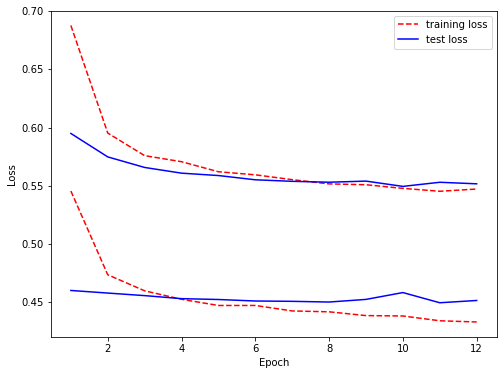

In [237]:
plt.figure(figsize=(8,6))

training_loss1_3 = history1_3.history['loss']
test_loss1_3 = history1_3.history['val_loss']
training_loss1_8 = history1_8.history['loss']
test_loss1_8 = history1_8.history['val_loss']

epoch_count1_3 = range(1,len(training_loss1_3)+1)
epoch_count1_8 = range(1,len(training_loss1_8)+1)

plt.plot(epoch_count1_3,training_loss1_3,'r--')
plt.plot(epoch_count1_3,test_loss1_3,'b-')
plt.plot(epoch_count1_8,training_loss1_8,'r--')
plt.plot(epoch_count1_8,test_loss1_8,'b-')

plt.legend(['training loss','test loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

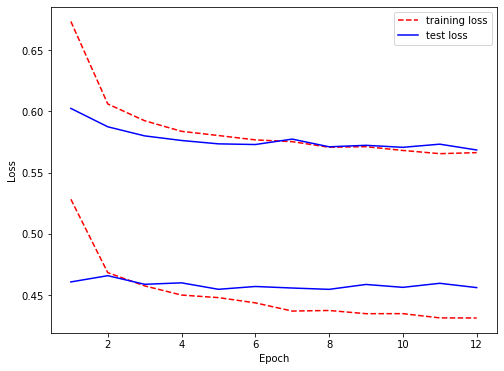

In [238]:
plt.figure(figsize=(8,6))

training_loss0_3 = history0_3.history['loss']
test_loss0_3 = history0_3.history['val_loss']
training_loss0_8 = history0_8.history['loss']
test_loss0_8 = history0_8.history['val_loss']

epoch_count0_3 = range(1,len(training_loss0_3)+1)
epoch_count0_8 = range(1,len(training_loss0_8)+1)

plt.plot(epoch_count0_3,training_loss0_3,'r--')
plt.plot(epoch_count0_3,test_loss0_3,'b-')
plt.plot(epoch_count0_8,training_loss0_8,'r--')
plt.plot(epoch_count0_8,test_loss0_8,'b-')

plt.legend(['training loss','test loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

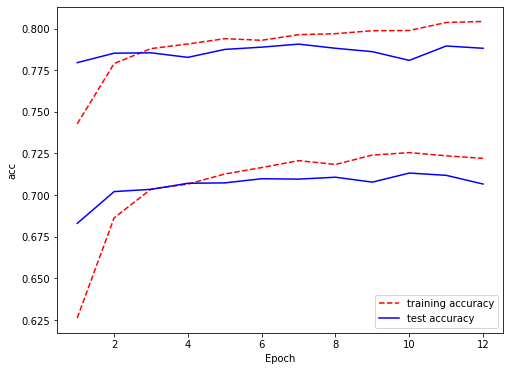

In [239]:
plt.figure(figsize=(8,6))

training_accuracy1_3 = history1_3.history['accuracy']
test_accuracy1_3 = history1_3.history['val_accuracy']
training_accuracy1_8 = history1_8.history['accuracy']
test_accuracy1_8 = history1_8.history['val_accuracy']

epoch_count1_3 = range(1,len(training_accuracy1_3)+1)
epoch_count1_8 = range(1,len(training_accuracy1_8)+1)

plt.plot(epoch_count1_3,training_accuracy1_3,'r--')
plt.plot(epoch_count1_3,test_accuracy1_3,'b-')
plt.plot(epoch_count1_8,training_accuracy1_8,'r--')
plt.plot(epoch_count1_8,test_accuracy1_8,'b-')

plt.legend(['training accuracy','test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.show()

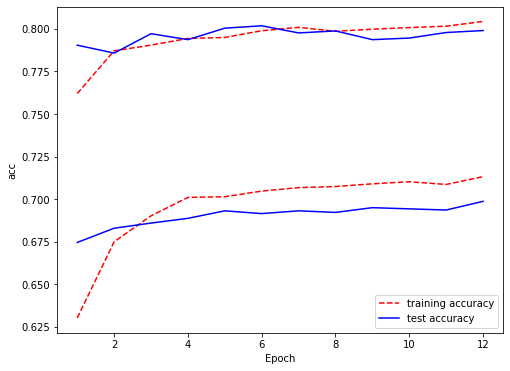

In [240]:
plt.figure(figsize=(8,6))

training_accuracy0_3 = history0_3.history['accuracy']
test_accuracy0_3 = history0_3.history['val_accuracy']
training_accuracy0_8 = history0_8.history['accuracy']
test_accuracy0_8 = history0_8.history['val_accuracy']

epoch_count0_3 = range(1,len(training_accuracy0_3)+1)
epoch_count0_8 = range(1,len(training_accuracy0_8)+1)

plt.plot(epoch_count0_3,training_accuracy0_3,'r--')
plt.plot(epoch_count0_3,test_accuracy0_3,'b-')
plt.plot(epoch_count0_8,training_accuracy0_8,'r--')
plt.plot(epoch_count0_8,test_accuracy0_8,'b-')

plt.legend(['training accuracy','test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.show()

In [241]:
pred_table0 = test0[['単勝','number']]
pred_table0[['score_<3']] = pd.DataFrame(network0_3.predict(X_test0),index=test0.index).groupby(level=0).transform(standard_scaler)
pred_table0[['score_<8']] = pd.DataFrame(network0_8.predict(X_test0),index=test0.index).groupby(level=0).transform(standard_scaler)

pred_table1 = test1[['単勝','number']]
pred_table1[['score_<3']] = pd.DataFrame(network1_3.predict(X_test1),index=test1.index).groupby(level=0).transform(standard_scaler)
pred_table1[['score_<8']] = pd.DataFrame(network1_8.predict(X_test1),index=test1.index).groupby(level=0).transform(standard_scaler)

pred_table2 = test2[['単勝','number']]
pred_table2[['score_<3']] = pd.DataFrame(network2_3.predict(X_test2),index=test2.index).groupby(level=0).transform(standard_scaler)
pred_table2[['score_<8']] = pd.DataFrame(network2_8.predict(X_test2),index=test2.index).groupby(level=0).transform(standard_scaler)

pred_table0 = pred_table0.copy()
pred_table0['score'] = (pred_table0['score_<3']*2+pred_table0['score_<8'])/3
pred_table1 = pred_table1.copy()
pred_table1['score'] = (pred_table1['score_<3']*2+pred_table1['score_<8'])/3
pred_table2 = pred_table2.copy()
pred_table2['score'] = (pred_table2['score_<3']*2+pred_table2['score_<8'])/3

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [242]:
params_nn = {}
lgb_clf = lgb.LGBMClassifier(**params_nn)
me = ModelEvaluator(lgb_clf,['return_tables_2014-20220220.pickle'])

In [243]:
me.tansho['R'] = me.tansho.index.str[-2:].astype(int)
me.tansho['place'] = me.tansho.index.str[4:6].astype(int)
tansho = me.tansho[me.tansho['R']>5]

In [244]:
human_predict={}
for n in range(1,6):
    human_predict[n] = tansho[tansho['ninki']<=n].index.nunique()/tansho.index.nunique()*100
human_predict

{1: 30.92005114778055,
 2: 49.41240942580527,
 3: 62.78998964866346,
 4: 72.41064360957195,
 5: 79.68702429519577}

In [245]:
result0={}
for top in tqdm(range(1,6)):
    #予想結果から上位N個を抜き出したリストを作成
    race_id_list = pred_table0.index.unique()
    #top = 1
    pred_table_top = pd.DataFrame()
    for race_id in race_id_list:
        pred_table_top = pred_table_top.append(pred_table0.loc[race_id].sort_values('score', ascending=False)[:top])

    #上位N個を抜き出したリストの予実評価
    match = 0
    if top == 1:
        for race_id in race_id_list:
            if me.tansho.loc[race_id]['win'] == pred_table_top.loc[race_id]['number']:
                match+=1
    if top != 1:
        for race_id in race_id_list:
            if me.tansho.loc[race_id]['win'] in list(pred_table_top.loc[race_id]['number']):
                match+=1
    result0[top] = match/race_id_list.nunique()*100
result0

{1: 27.419354838709676,
 2: 42.25806451612903,
 3: 56.12903225806451,
 4: 65.48387096774194,
 5: 73.54838709677419}

In [246]:
result1={}
for top in tqdm(range(1,6)):
    #予想結果から上位N個を抜き出したリストを作成
    race_id_list = pred_table1.index.unique()
    #top = 1
    pred_table_top = pd.DataFrame()
    for race_id in race_id_list:
        pred_table_top = pred_table_top.append(pred_table1.loc[race_id].sort_values('score', ascending=False)[:top])

    #上位N個を抜き出したリストの予実評価
    match = 0
    if top == 1:
        for race_id in race_id_list:
            if me.tansho.loc[race_id]['win'] == pred_table_top.loc[race_id]['number']:
                match+=1
    if top != 1:
        for race_id in race_id_list:
            if me.tansho.loc[race_id]['win'] in list(pred_table_top.loc[race_id]['number']):
                match+=1
    result1[top] = match/race_id_list.nunique()*100
result1

{1: 30.357142857142854,
 2: 48.51190476190476,
 3: 62.5,
 4: 73.21428571428571,
 5: 79.76190476190477}

In [247]:
result2={}
for top in tqdm(range(1,6)):
    #予想結果から上位N個を抜き出したリストを作成
    race_id_list = pred_table2.index.unique()
    #top = 1
    pred_table_top = pd.DataFrame()
    for race_id in race_id_list:
        pred_table_top = pred_table_top.append(pred_table2.loc[race_id].sort_values('score', ascending=False)[:top])

    #上位N個を抜き出したリストの予実評価
    match = 0
    if top == 1:
        for race_id in race_id_list:
            if me.tansho.loc[race_id]['win'] == pred_table_top.loc[race_id]['number']:
                match+=1
    if top != 1:
        for race_id in race_id_list:
            if me.tansho.loc[race_id]['win'] in list(pred_table_top.loc[race_id]['number']):
                match+=1
    result2[top] = match/race_id_list.nunique()*100
result2

{1: 22.727272727272727,
 2: 38.06818181818182,
 3: 52.84090909090909,
 4: 63.06818181818182,
 5: 71.02272727272727}

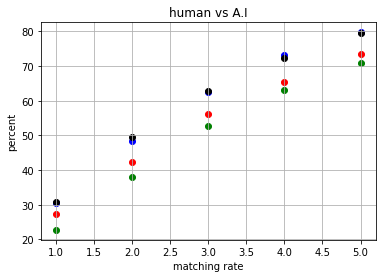

In [248]:
x0,y0 = zip(*result0.items())
x1,y1 = zip(*result1.items())
x2,y2 = zip(*result2.items())
x3,y3 = zip(*human_predict.items())
plt.scatter(x0,y0,color='red')
plt.scatter(x1,y1,color='blue')
plt.scatter(x2,y2,color='green')
plt.scatter(x3,y3,color='black')
plt.title('human vs A.I')
plt.xlabel('matching rate')
plt.ylabel('percent')
plt.grid(True)

In [249]:
tansho0 = calc_gain(me.calc_test_return, pred_table0)
tansho1 = calc_gain(me.calc_test_return, pred_table1)
tansho2 = calc_gain(me.calc_test_return, pred_table2)

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1318: RuntimeWarning: invalid value encountered in double_scalars
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1318: RuntimeWarning: invalid value encountered in double_scalars
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1318: RuntimeWarning: invalid value encountered in double_scalars
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

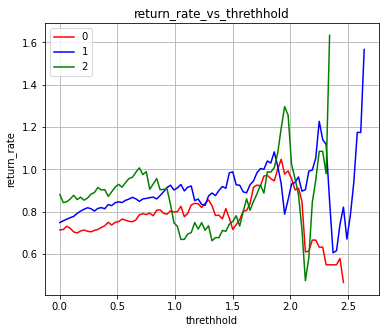

In [250]:
plt.figure(figsize=(6,5))
plt.plot(tansho0.index,tansho0['return_rate'],color='red')
plt.plot(tansho1.index,tansho1['return_rate'],color='blue')
plt.plot(tansho2.index,tansho2['return_rate'],color='green')
plt.title('return_rate_vs_threthhold')
plt.xlabel('threthhold')
plt.ylabel('return_rate')
plt.legend(['0','1','2',])
plt.grid(True)

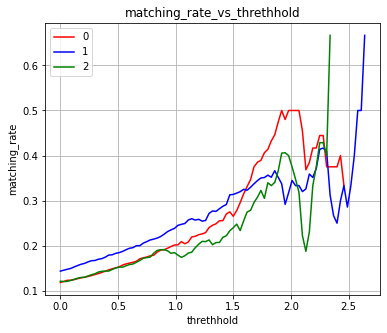

In [251]:
plt.figure(figsize=(6,5))
plt.plot(tansho0.index,tansho0['n_hits']/tansho0['n_bets'],color='red')
plt.plot(tansho1.index,tansho1['n_hits']/tansho1['n_bets'],color='blue')
plt.plot(tansho2.index,tansho2['n_hits']/tansho2['n_bets'],color='green')
plt.title('matching_rate_vs_threthhold')
plt.xlabel('threthhold')
plt.ylabel('matching_rate')
plt.legend(['0','1','2'])
plt.grid(True)

In [252]:
del X_test0,X_test1,X_test2,X_train0,X_train1,X_train2,X_valid0,X_valid1,X_valid2,test0,test1,test2,valid0,valid1,valid2,

# Shutuba_data

In [259]:
race_id1 = ['2022060201{}'.format(str(i).zfill(2)) for i in range(5,13,1)]
race_id2 = ['2022090105{}'.format(str(i).zfill(2)) for i in range(5,13,1)]
race_id3 = ['2022100205{}'.format(str(i).zfill(2)) for i in range(5,13,1)]
race_id4 = ['2022060202{}'.format(str(i).zfill(2)) for i in range(5,13,1)]
race_id5 = ['2022090106{}'.format(str(i).zfill(2)) for i in range(5,13,1)]
race_id6 = ['2022100206{}'.format(str(i).zfill(2)) for i in range(5,13,1)]

race_id_list = race_id1 + race_id2 + race_id3 + race_id4 + race_id5 + race_id6
#race_id_list.remove('202106050909')
st = ShutubaTable.scrape(race_id_list, '2022/2/26')

In [260]:
#st.data = st.data[st.data['horse_id'] != '2019100481']
#st.data = st.data[st.data['jockey_id'] != '2019105564']

st.preprocessing(weight=True)
st.merge_horse_results(hr,n_samples_list=[1,2,4,7])
st.merge_jockey_results(jr,n_samples_list=[60,120])
st.merge_trainer_results(tr,n_samples_list=[120])
st.data_p.dropna(subset=['h_rank/heads_1R'],inplace=True)

st.process_categorical(r.data_p,st=True)
#st.process_categorical(r.le_horse,r.le_jockey,r.le_trainer,r.data_p,st=True)
#st.data_x = st.data_c.copy()

In [261]:
df_vs = pd.DataFrame()
df_vs = pd.DataFrame(st.data_c[f_params].add_prefix('vs_')).groupby(level=0).transform(standard_scaler)
st.data_c = pd.concat([st.data_c,df_vs],axis=1)
st.data_c = st.data_c.fillna(r.data_c.median())

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [262]:
pred_table_st0 = st.data_c[st.data_c['place']==place[0]].copy()
pred_table_st1 = st.data_c[st.data_c['place']==place[1]].copy()
pred_table_st2 = st.data_c[st.data_c['place']==place[2]].copy()

In [263]:
pred0_3 = pd.DataFrame(network0_3.predict(transform_input2(pred_table_st0)),index=pred_table_st0.index).groupby(level=0).transform(standard_scaler)
pred0_8 = pd.DataFrame(network0_8.predict(transform_input2(pred_table_st0)),index=pred_table_st0.index).groupby(level=0).transform(standard_scaler)
pred1_3 = pd.DataFrame(network1_3.predict(transform_input2(pred_table_st1)),index=pred_table_st1.index).groupby(level=0).transform(standard_scaler)
pred1_8 = pd.DataFrame(network1_8.predict(transform_input2(pred_table_st1)),index=pred_table_st1.index).groupby(level=0).transform(standard_scaler)
pred2_3 = pd.DataFrame(network2_3.predict(transform_input2(pred_table_st2)),index=pred_table_st2.index).groupby(level=0).transform(standard_scaler)
pred2_8 = pd.DataFrame(network2_8.predict(transform_input2(pred_table_st2)),index=pred_table_st2.index).groupby(level=0).transform(standard_scaler)

pred_table_st0['pred_nn_3'] = pred0_3
pred_table_st0['pred_nn_8'] = pred0_8
pred_table_st0['pred_nn_art'] = (pred0_3*2+pred0_8)/3
pred_table_st1['pred_nn_3'] = pred1_3
pred_table_st1['pred_nn_8'] = pred1_8
pred_table_st1['pred_nn_art'] = (pred1_3*2+pred1_8)/3
pred_table_st2['pred_nn_3'] = pred2_3
pred_table_st2['pred_nn_8'] = pred2_8
pred_table_st2['pred_nn_art'] = (pred2_3*2+pred2_8)/3
target_param = ['number','waku_winrate','horse','days','interval','++weight','speed_4R','spurt_4R','differ_4R','1st_corner_4R',\
                'style_winrate','jockey','jp_rate_mean','trainer','tp_rate_mean','popularity','ozz','pred_nn_3','pred_nn_8','pred_nn_art']

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1372: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1372: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1372: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1372: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1372: FutureWar

## 中山

In [264]:
No = '10'
raceid = ['2022060202'+str(No)]
st0 = Ozz()
st0.scrape_ozz(raceid)
st0.columns_change()
df = pred_table_st0.loc[raceid].merge(st0.ozz,left_index=True,on='number')
df = df[target_param].sort_values('pred_nn_art',ascending=False)
print('中山'+str(No),course_type(pred_table_st0.loc[raceid]['race_type_芝'][0]),str(int(pred_table_st0.loc[raceid]['course_len'][0]))+'m')
dfi.export(df, str(raceid)+'.jpeg')
df.reset_index().style.background_gradient(cmap='Wistia')


中山10 ダート 1200m


,index,number,waku_winrate,horse,days,interval,++weight,speed_4R,spurt_4R,differ_4R,1st_corner_4R,style_winrate,jockey,jp_rate_mean,trainer,tp_rate_mean,popularity,ozz,pred_nn_3,pred_nn_8,pred_nn_art
0,202206020210,16,0.219071,ジゲン,4.942466,3.526361,0.000000,1.432233,1.059236,0.787784,3.500000,0.238974,田辺,0.363029,浅見,0.288462,6,10.800000,1.534967,1.261132,1.443689
1,202206020210,9,0.189681,スワーヴシャルル,6.065753,3.332205,0.000000,1.315901,0.799582,0.647021,7.000000,0.188506,川田,0.406250,安田隆,0.353383,2,5.300000,1.339024,1.259153,1.312400
2,202206020210,1,0.171802,アウトウッズ,5.054795,4.934474,0.000000,1.652710,1.447490,0.616194,7.750000,0.188506,津村,0.198903,浅見,0.288462,3,5.800000,1.128942,1.561053,1.272979
3,202206020210,12,0.214775,イディオム,3.928767,2.995732,0.000000,1.099760,0.720542,0.792408,2.250000,0.253698,西村淳,0.000000,斎藤誠,0.284836,4,8.700000,0.741540,0.338009,0.607030
4,202206020210,15,0.219071,ラホーヤノキセキ,7.761644,4.718499,0.000000,1.591643,0.712257,0.792189,3.750000,0.238974,森一,0.375000,松永昌,0.303030,8,19.400000,0.920463,-0.151565,0.563121
5,202206020210,11,0.214775,ディスモーメント,5.824658,4.234107,0.000000,1.159526,1.428615,0.791887,11.500000,0.138462,石橋脩,0.259640,宮田,0.362069,9,21.100000,0.412328,0.822181,0.548946
6,202206020210,6,0.179602,カイアワセ,4.879452,4.127134,0.000000,1.445707,0.710349,0.630749,3.000000,0.238974,戸崎圭,0.377027,鈴木慎,0.142857,5,9.300000,0.349191,0.737724,0.478702
7,202206020210,13,0.210964,ハコダテブショウ,3.843836,3.951244,0.000000,0.475649,-0.179942,-0.139362,2.000000,0.253698,石川,0.188769,相沢,0.247041,1,4.600000,0.464295,-0.296713,0.210626
8,202206020210,10,0.189681,ニシノライトニング,3.986301,2.995732,0.000000,1.110779,2.031685,0.672592,13.750000,0.122200,野中,0.093052,根本,0.112536,7,13.800000,-0.296573,0.860046,0.088966
9,202206020210,3,0.169526,ノアヴィグラス,3.890411,5.241747,0.000000,1.436675,0.434088,0.924316,1.250000,0.253698,吉田豊,0.204569,古賀史,0.266501,11,24.900000,-0.219909,-0.443301,-0.294373


In [267]:
No = '12'
raceid = ['2022060202'+str(No)]
st0 = Ozz()
st0.scrape_ozz(raceid)
st0.columns_change()
df = pred_table_st0.loc[raceid].merge(st0.ozz,left_index=True,on='number')
df = df[target_param].sort_values('pred_nn_art',ascending=False)
print('中山'+str(No),course_type(pred_table_st0.loc[raceid]['race_type_芝'][0]),str(int(pred_table_st0.loc[raceid]['course_len'][0]))+'m')
dfi.export(df, str(raceid)+'.jpeg')
df.reset_index().style.background_gradient(cmap='Wistia')


中山12 ダート 1800m


,index,number,waku_winrate,horse,days,interval,++weight,speed_4R,spurt_4R,differ_4R,1st_corner_4R,style_winrate,jockey,jp_rate_mean,trainer,tp_rate_mean,popularity,ozz,pred_nn_3,pred_nn_8,pred_nn_art
0,202206020212,12,0.231667,ロンコーネ,3.961644,3.295837,0.000000,1.282524,0.501823,0.929958,6.000000,0.208289,戸崎圭,0.377027,岩戸,0.209726,2,4.100000,2.215798,1.668810,2.033469
1,202206020212,5,0.180513,アナンシエーション,3.797260,3.044522,0.000000,1.242775,0.646468,0.909668,4.750000,0.261490,石川,0.188769,手塚,0.305660,1,1.800000,1.709255,2.111008,1.843173
2,202206020212,15,0.225209,ダイワドノヴァン,7.786301,3.044522,0.000000,1.127723,0.227070,0.660547,10.000000,0.171113,田辺,0.363029,池上,0.224719,3,12.000000,1.074916,0.614193,0.921342
3,202206020212,9,0.222756,ゴールドフレーム,6.041096,4.418841,0.000000,1.108729,0.953122,0.185259,11.500000,0.171113,北村宏,0.250316,新開,0.282332,10,31.300000,0.372846,0.101750,0.282481
4,202206020212,1,0.180516,ヨンク,6.002740,3.044522,0.000000,0.916476,1.549065,0.558733,11.750000,0.171113,三浦,0.308522,小笠,0.208505,9,31.000000,0.038012,0.730239,0.268754
5,202206020212,11,0.213982,ロングラン,4.049315,4.983607,0.000000,0.529401,1.921243,0.155032,10.500000,0.171113,大野,0.250977,和田勇,0.184524,7,21.200000,-0.156968,0.083270,-0.076888
6,202206020212,10,0.213982,コスモオリ,4.997260,2.639057,0.000000,0.554518,0.397193,0.364146,12.500000,0.136391,津村,0.198903,高橋祥,0.192063,8,21.900000,-0.368985,0.071139,-0.222277
7,202206020212,3,0.184690,ルドヴィクス,3.947945,3.737670,0.000000,-0.077643,-0.383465,0.060872,3.000000,0.261490,菅原明,0.187898,久保田,0.334959,4,17.400000,-0.485475,-0.273795,-0.414915
8,202206020212,7,0.179273,ルヴェルソー,5.090411,3.951244,0.000000,0.443504,0.086705,0.213380,3.750000,0.261490,内田博,0.214141,田中博,0.324324,5,18.200000,-0.382503,-0.917670,-0.560892
9,202206020212,13,0.231667,フォギーデイ,4.841096,5.342334,0.000000,0.537452,-0.554316,0.733639,3.250000,0.261490,横山琉,0.111111,水野,0.197817,14,88.300000,-0.542454,-1.080613,-0.721840


## 阪神

In [266]:
No = '12'
raceid = ['2022090106'+str(No)]
st1 = Ozz()
st1.scrape_ozz(raceid)
st1.columns_change()
df = pred_table_st1.loc[raceid].merge(st1.ozz,left_index=True,on='number')
df = df[target_param].sort_values('pred_nn_art',ascending=False)
print('阪神'+str(No),course_type(pred_table_st1.loc[raceid]['race_type_芝'][0]),str(int(pred_table_st1.loc[raceid]['course_len'][0]))+'m')
dfi.export(df, str(raceid)+'.jpeg')
df.reset_index().style.background_gradient(cmap='Wistia')


阪神12 ダート 1400m


,index,number,waku_winrate,horse,days,interval,++weight,speed_4R,spurt_4R,differ_4R,1st_corner_4R,style_winrate,jockey,jp_rate_mean,trainer,tp_rate_mean,popularity,ozz,pred_nn_3,pred_nn_8,pred_nn_art
0,202209010612,12,0.206758,エターナリー,4.926027,3.295837,0.000000,1.098434,0.938223,0.655503,3.750000,0.259133,岩田康,0.298271,辻野,0.107143,1,3.700000,1.867801,1.424825,1.720142
1,202209010612,15,0.219319,レッドブロンクス,4.860274,4.418841,0.000000,0.907855,0.758519,0.827093,6.500000,0.193474,武豊,0.409699,石坂,0.252336,2,5.900000,1.811892,1.185085,1.602956
2,202209010612,5,0.180796,メラナイト,6.849315,3.044522,0.000000,1.182686,1.236683,0.783473,8.000000,0.193474,鮫島駿,0.166963,佐々木,0.213220,4,9.600000,1.116547,0.917906,1.050334
3,202209010612,1,0.159696,ジョウショーリード,4.838356,3.332205,0.000000,0.700669,0.200465,0.380541,8.750000,0.193474,高倉,0.127721,服部,0.135854,12,22.400000,0.920753,1.171638,1.004381
4,202209010612,4,0.184889,サトノムスタング,4.002740,3.295837,0.000000,0.434584,0.207477,0.019995,8.750000,0.193474,岩田望,0.292271,大和田,0.086957,3,6.300000,0.643859,1.060966,0.782895
5,202209010612,11,0.206758,ラキ,4.901370,3.332205,0.000000,0.557568,0.328896,-0.068774,9.500000,0.159204,小崎,0.122616,小崎,0.225700,5,10.300000,0.184067,0.790473,0.386202
6,202209010612,9,0.219672,トゥインクルリーフ,5.953425,2.564949,0.000000,0.612339,-0.143564,0.400234,6.750000,0.193474,藤岡康,0.228956,吉岡,0.260870,7,16.400000,0.151086,0.217049,0.173074
7,202209010612,16,0.219319,マイナーズライト,3.986301,3.295837,0.000000,0.799930,1.445930,0.613172,12.500000,0.096633,幸,0.250469,大江原,0.153846,10,19.500000,-0.150832,-0.326380,-0.209348
8,202209010612,13,0.222399,スズカクローカス,5.830137,3.951244,0.000000,0.969736,1.541477,0.355581,12.500000,0.096633,長岡,0.089041,杉山佳,0.255814,6,14.300000,-0.674329,-0.222881,-0.523846
9,202209010612,7,0.199499,ペガサスターボ,4.810959,3.295837,0.000000,0.754926,1.369722,0.632152,13.000000,0.096633,和田竜,0.260563,勢司,0.155556,13,40.100000,-0.678729,-0.453171,-0.603543


In [265]:
No = '12'
raceid = ['2022090106'+str(No)]
st1 = Ozz()
st1.scrape_ozz(raceid)
st1.columns_change()
df = pred_table_st1.loc[raceid].merge(st1.ozz,left_index=True,on='number')
df = df[target_param].sort_values('pred_nn_art',ascending=False)
print('阪神'+str(No),course_type(pred_table_st1.loc[raceid]['race_type_芝'][0]),str(int(pred_table_st1.loc[raceid]['course_len'][0]))+'m')
dfi.export(df, str(raceid)+'.jpeg')
df.reset_index().style.background_gradient(cmap='Wistia')


阪神12 ダート 1400m


,index,number,waku_winrate,horse,days,interval,++weight,speed_4R,spurt_4R,differ_4R,1st_corner_4R,style_winrate,jockey,jp_rate_mean,trainer,tp_rate_mean,popularity,ozz,pred_nn_3,pred_nn_8,pred_nn_art
0,202209010612,12,0.206758,エターナリー,4.926027,3.295837,0.000000,1.098434,0.938223,0.655503,3.750000,0.259133,岩田康,0.298271,辻野,0.107143,1,3.700000,1.867801,1.424825,1.720142
1,202209010612,15,0.219319,レッドブロンクス,4.860274,4.418841,0.000000,0.907855,0.758519,0.827093,6.500000,0.193474,武豊,0.409699,石坂,0.252336,2,5.900000,1.811892,1.185085,1.602956
2,202209010612,5,0.180796,メラナイト,6.849315,3.044522,0.000000,1.182686,1.236683,0.783473,8.000000,0.193474,鮫島駿,0.166963,佐々木,0.213220,4,9.600000,1.116547,0.917906,1.050334
3,202209010612,1,0.159696,ジョウショーリード,4.838356,3.332205,0.000000,0.700669,0.200465,0.380541,8.750000,0.193474,高倉,0.127721,服部,0.135854,12,22.400000,0.920753,1.171638,1.004381
4,202209010612,4,0.184889,サトノムスタング,4.002740,3.295837,0.000000,0.434584,0.207477,0.019995,8.750000,0.193474,岩田望,0.292271,大和田,0.086957,3,6.300000,0.643859,1.060966,0.782895
5,202209010612,11,0.206758,ラキ,4.901370,3.332205,0.000000,0.557568,0.328896,-0.068774,9.500000,0.159204,小崎,0.122616,小崎,0.225700,5,10.300000,0.184067,0.790473,0.386202
6,202209010612,9,0.219672,トゥインクルリーフ,5.953425,2.564949,0.000000,0.612339,-0.143564,0.400234,6.750000,0.193474,藤岡康,0.228956,吉岡,0.260870,7,16.400000,0.151086,0.217049,0.173074
7,202209010612,16,0.219319,マイナーズライト,3.986301,3.295837,0.000000,0.799930,1.445930,0.613172,12.500000,0.096633,幸,0.250469,大江原,0.153846,10,19.500000,-0.150832,-0.326380,-0.209348
8,202209010612,13,0.222399,スズカクローカス,5.830137,3.951244,0.000000,0.969736,1.541477,0.355581,12.500000,0.096633,長岡,0.089041,杉山佳,0.255814,6,14.300000,-0.674329,-0.222881,-0.523846
9,202209010612,7,0.199499,ペガサスターボ,4.810959,3.295837,0.000000,0.754926,1.369722,0.632152,13.000000,0.096633,和田竜,0.260563,勢司,0.155556,13,40.100000,-0.678729,-0.453171,-0.603543


## 小倉

In [268]:
No = '12'
raceid = ['2022100206'+str(No)]
st2 = Ozz()
st2.scrape_ozz(raceid)
st2.columns_change()
df = pred_table_st2.loc[raceid].merge(st2.ozz,left_index=True,on='number')
df = df[target_param].sort_values('pred_nn_art',ascending=False)
print('小倉'+str(No),course_type(pred_table_st2.loc[raceid]['race_type_芝'][0]),str(int(pred_table_st2.loc[raceid]['course_len'][0]))+'m')
dfi.export(df, str(raceid)+'.jpeg')
df.reset_index().style.background_gradient(cmap='Wistia')


小倉12 芝 2000m


,index,number,waku_winrate,horse,days,interval,++weight,speed_4R,spurt_4R,differ_4R,1st_corner_4R,style_winrate,jockey,jp_rate_mean,trainer,tp_rate_mean,popularity,ozz,pred_nn_3,pred_nn_8,pred_nn_art
0,202210020612,5,0.221219,エニシノウタ,3.832877,2.564949,0.000000,0.426454,0.379897,0.718860,7.750000,0.238983,吉田隼,0.264198,笹田,0.258964,6,10.000000,1.623689,1.366492,1.537957
1,202210020612,10,0.232742,ネグローニ,4.098630,2.564949,0.000000,0.710293,0.030444,0.753618,5.000000,0.251613,川須,0.161034,矢作,0.293532,4,6.700000,1.625741,0.529498,1.260327
2,202210020612,3,0.224880,ウインミニヨン,3.961644,2.564949,0.000000,0.445451,0.537723,0.223040,11.750000,0.196739,横山和,0.268571,長谷川,0.230769,1,4.600000,1.069608,1.534576,1.224598
3,202210020612,14,0.198128,ヒットザシーン,3.950685,1.791759,0.000000,0.302353,-0.323966,0.612150,5.250000,0.251613,小沢,0.115385,畠山,0.189189,7,20.000000,0.811887,1.189022,0.937599
4,202210020612,1,0.187032,レディアリエス,3.931507,3.737670,0.000000,0.457503,0.992035,0.550436,8.500000,0.238983,浜中,0.363465,橋口,0.323529,3,5.700000,0.766441,1.017362,0.850081
5,202210020612,13,0.198128,スウィートブルーム,3.865753,4.330733,0.000000,0.558150,-0.245572,-0.037875,5.750000,0.251613,丹内,0.248175,和田雄,0.041667,2,5.600000,0.918825,0.621981,0.819877
6,202210020612,15,0.224888,フォレスタ,3.860274,3.295837,0.000000,0.680640,-0.002778,0.548078,6.500000,0.238983,角田,0.109890,田中清,0.129032,5,7.500000,0.128550,0.349113,0.202071
7,202210020612,7,0.246347,ローズパルファン,4.830137,1.945910,0.000000,-0.505009,-0.076888,-0.146178,8.250000,0.238983,荻野極,0.162465,田中剛,0.137931,10,29.400000,-0.185725,-0.261238,-0.210896
8,202210020612,11,0.229323,ミスカイウラニ,3.884932,2.639057,0.000000,0.404354,-0.083213,-0.236586,10.250000,0.196739,永島,0.037037,平田,0.189759,9,25.900000,-0.431771,-0.190069,-0.351203
9,202210020612,4,0.224880,シャインユニバンス,3.945205,2.639057,0.000000,0.189652,0.859451,0.517338,9.250000,0.196739,原田和,0.101449,田村,0.216216,15,52.100000,-0.633897,-0.059622,-0.442472


# RF

In [181]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [182]:
rf = RFR(n_estimators=80, max_features='auto')

In [206]:
df = pd.read_pickle('r_data_c_2014-20220213.pickle')
train, test = split_data(df.fillna(r.data_c.median()),1/6)
train, valid = split_data(train,1/5)

X_train_dl = train.drop(['rank=1','rank<2','rank<3','rank<5','rank<8','date','birth','単勝'],axis=1)
y_train_dl = train['rank<3']
X_test_dl = test.drop(['rank=1','rank<2','rank<3','rank<5','rank<8','date','birth','単勝'],axis=1)
y_test_dl = test['rank<3']

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [207]:
rf.fit(X_train_dl,y_train_dl)

RandomForestRegressor(n_estimators=80)

<AxesSubplot:>

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 33437 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/matplotlib/b

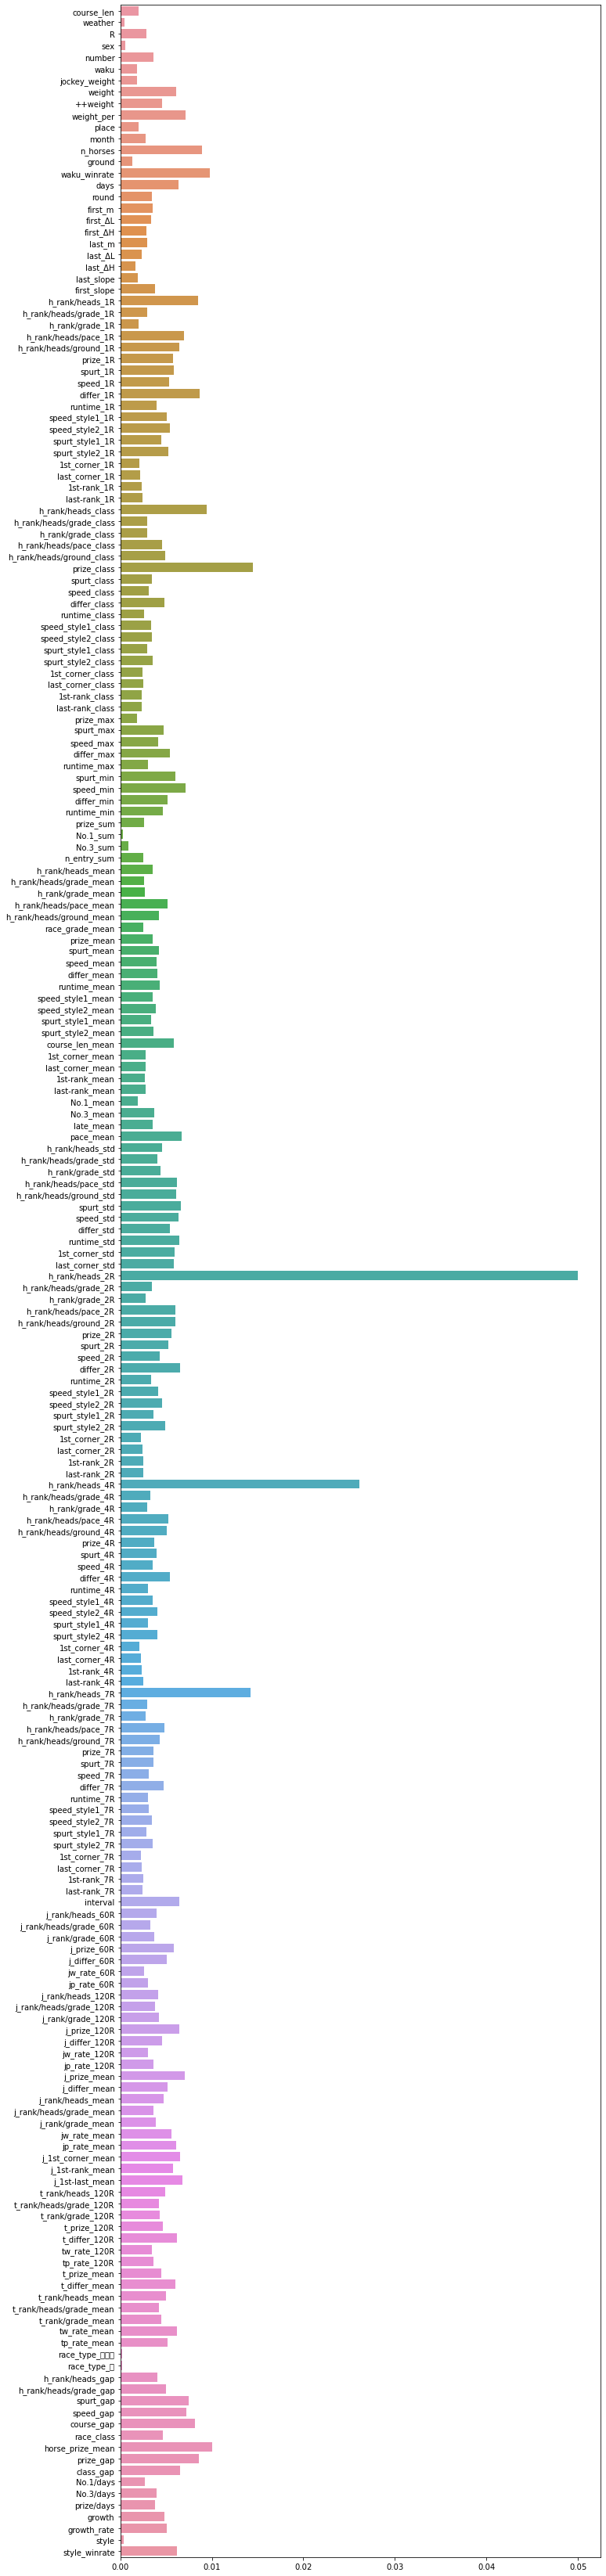

In [208]:
f, ax = plt.subplots(figsize=(11, 60))
sns.barplot(x=rf.feature_importances_, y=X_train_dl.columns.values, orient='h')

# analyze

In [141]:
test = r.data_c.copy()

In [142]:
wins = test[test['rank=1']==1]

In [135]:
wins.groupby()

<AxesSubplot:>

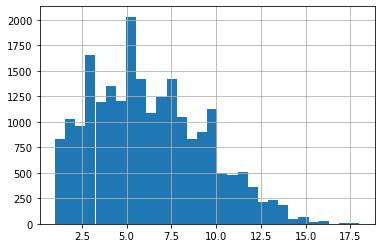

In [136]:
x0.hist(bins=30)

In [137]:
x1 = test['1st_corner_7R']
x1 = test['1st_corner_7R']

<AxesSubplot:>

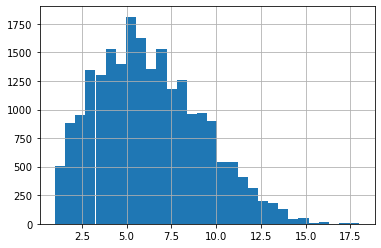

In [138]:
x1.hist(bins=30)

In [139]:
x2 = test['1st_corner_2R']

<AxesSubplot:>

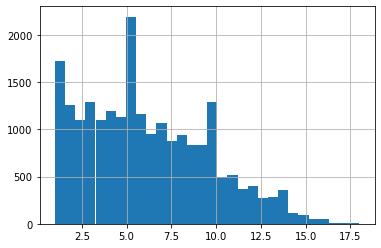

In [140]:
x2.hist(bins=30)

In [ ]:
self.data_p_ = self.data_p[['place','course_len','race_type','waku']]
        self.data_p_rank = self.data_p_rank[['place','course_len','race_type','waku']]
        self.data_p_grp = self.data_p_.groupby(['place','race_type','course_len','waku'])
        self.data_p_rank_grp = self.data_p_rank.groupby(['place','race_type','course_len','waku'])
        self.data_num_rate = self.data_p_rank_grp.count()/self.data_p_grp.count()
        self.data_num_rate['waku_winrate'] = self.data_num_rate['着順'].map(lambda x: 0.5 if x>0.5 else x)
        df_join = df.join(self.data_num_rate['waku_winrate'],on=['place','race_type','course_len','waku'])

In [92]:
data = data[data['rank=1']==1]
data = data[data['place']==9]
data = data[data['course_len']==1400]

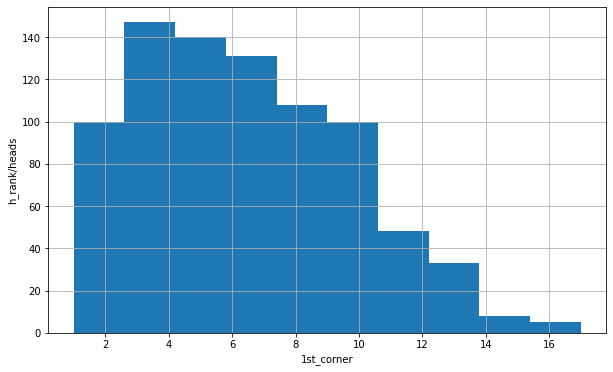

In [90]:
plt.figure(figsize=(10,6))
y = data['h_rank/heads_4R']
x = data['1st_corner_4R']
x1 = data['1st-rank_4R']
x2 = data['last-rank_4R']

plt.hist(x)
#plt.title('human vs A.I')
plt.xlabel('1st_corner')
plt.ylabel('h_rank/heads')
plt.grid(True)

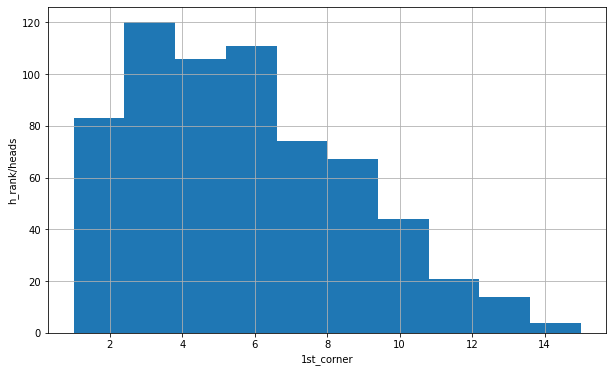

In [93]:
plt.figure(figsize=(10,6))
y = data['h_rank/heads_4R']
x = data['1st_corner_4R']
x1 = data['1st-rank_4R']
x2 = data['last-rank_4R']

plt.hist(x)
#plt.title('human vs A.I')
plt.xlabel('1st_corner')
plt.ylabel('h_rank/heads')
plt.grid(True)